## HIGH DIMENSIONAL ANALYSIS

*   **Programing Exercise: 04**
*   **Name: Đinh Anh Huy**
*   **Student code       : 18110103**




### 1. Write a summary of the t-SNE.

t-Distributed Stochastic Neighbor Embedding (t-SNE) là một phương pháp thống kê giúp giảm số chiều của dữ liệu phi tuyến tính, rất phù hợp để nhúng dữ liệu với số chiều lớn $(\textbf{x}_1, \textbf{x}_2,...,\textbf{x}_N)^T \in \mathbb{R}^{N\times d}$ vào không gian có số chiều nhỏ hơn $(\textbf{y}_1, \textbf{y}_2,...,\textbf{y}_N)^T \in \mathbb{R}^{N\times m}$. Nó được xây dựng dựa trên Stochastic Neighbor Embedding ban đầu được phát triển bởi Sam Roweis và Geoffrey Hinton, sau đó được Laurens van der Maaten đề xuất một biến thể kết hợp với phân phối Student.

Trong thuật toán t-SNE, ta xét xác suất Gaussian xung quanh mọi điểm $\textbf{x}_i, i=1,...,N$ trong không gian input vì crowding problem không xảy ra ở dữ liệu có số chiều lớn. Xác suất để điểm $\textbf{x}_i\in\mathbb{R}^d$ lấy điểm $\textbf{x}_j\in\mathbb{R}^d$ làm neighbor là
$$ p_{j|i} = \dfrac{\exp(-d_{ij}^2)}{\sum_{k\neq i}\exp(-d_{ik}^2)}, \scriptsize(1)$$ 
trong đó
$$d_{ij}^2 = \dfrac{\|\textbf{x}_i - \textbf{x}_j\|^2}{2\sigma_i^2},\quad p_{i|i}=0\quad\text{và}\quad\displaystyle\sum_{j}p_{j|i}=1,\forall i$$

Lưu ý rằng công thức (1) không có tính đối xứng với $i$ và $j$ do mẫu số khác nhau. Ta xét $p_{ij}$ đối xứng được cho như sau
\begin{equation}
    p_{ij} = \dfrac{p_{i|j} + p_{j|i}}{2N}, \scriptsize(2)
\end{equation}
trong đó
$$p_{ij} = p_{ji},\quad p_{ii}=0\quad\text{và}\quad\displaystyle\sum_{i,j}p_{ij}=1.$$

Trong không gian embedded có số chiều nhỏ, ta xét phân phối Student cho điểm $\textbf{y}_i\in\mathbb{R}^m, i=1,...,N$. Xác suất để điểm $\textbf{y}_i\in\mathbb{R}^m$ lấy điểm $\textbf{y}_j\in\mathbb{R}^m$ làm neighbor là
\begin{equation}
    q_{ij} = \dfrac{(1-z_{ij}^2)^{-1}}{\sum_{k\neq i}(1+z_{ki}^2)^{-1}}, \scriptsize(3)
\end{equation}
trong đó
$$z_{ij}^2 = \|\textbf{y}_i-\textbf{y}_j\|^2,\quad q_{ii}=0.$$

Ta mong muốn phân phối xác suất trong cả không gian input và embedded giống nhau nhất có thể; do đó, ta cần minimize cost function là tổng của các Kullback-Leibler divergences trên $N$ điểm
\begin{equation}
    C = \displaystyle\sum_{i=1}^NKL(P_i\parallel Q_i) = \displaystyle\sum_{i=1}^N\displaystyle\sum_{i\neq j=1}^Np_{ij}\log\left(\dfrac{p_{ij}}{q_{ij}}\right),
\end{equation}
trong đó $p_{ij}$ và $q_{ij}$ được định nghĩa ở công thức (2) và (3). Lưu ý rằng, tương tự như thuật toán SNE, do t-SNE sử dụng Kullback-Leibler divergence cho cost function nên thuật toán chỉ tập trung đám bảo cho local structure, tương tự như thuật toán SNE.

**Mệnh đề** Đạo hàm của $C$ theo $\textbf{y}_i$ là
\begin{equation}
    \dfrac{\partial C}{\partial \textbf{y}_i} = 4\displaystyle\sum_{j=1}^N(p_{ij}-q_{ij})(1+\|\textbf{y}_i-\textbf{y}_j\|^2)^{-1}(\textbf{y}_i-\textbf{y}_j),
\end{equation}
trong đó $p_{ij}$ và $q_{ij}$ được định nghĩa ở công thức (2) và (3), và $p_{ii} = q_{ii} = 0$.

Việc cập nhật các điểm embedded $\textbf{y}_i$ được thực hiện bằng phương pháp gradient descent với mỗi vòng lặp là
\begin{align}
    \begin{split}
        \Delta\textbf{y}_i^{(t)} &:= -\eta \dfrac{\partial C}{\partial\textbf{y}_i} + \alpha(t)\Delta \textbf{y}_i^{(t-1)},\\
        \textbf{y}_i^{(t)} &:= \textbf{y}_i^{(t-1)} + \Delta \textbf{y}_i^{(t)},
    \end{split}
\end{align}
trong đó momentum $\alpha(t)$ được sử dụng cho việc hội tụ tốt hơn. Nó có thể nhỏ hơn so với các lần lặp trước đó hoặc lớn hơn so với các lần lặp sau này. Ví dụ, ta có thể có
$$\alpha(t) = \left\{\begin{array}{ll}
    0.5 & t < 250, \\
    0.8 & t \geq 250
\end{array}\right.$$
và $\eta$ là learning rate, một hằng số dương nhỏ (ví dụ, $\eta = 0.1$) hoặc có thể được cập nhật sau mỗi vòng lặp.

### 2. Applying the t-SNE on Fashion-MNIST dataset.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ast import literal_eval
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go

In [ ]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

def visualize_2D(data, tsne_results, ax):
    data['tsne-2d-one'] = tsne_results[:,0]
    data['tsne-2d-two'] = tsne_results[:,1]
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="class",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.3,
        ax=ax
    )
    
def visualize_3D(data, tsne_results, ax):
    data['tsne-3d-one'] = tsne_results_3d[:,0]
    data['tsne-3d-two'] = tsne_results_3d[:,1]
    data['tsne-3d-three'] = tsne_results_3d[:,2]
    ax.scatter(
        xs=data['tsne-3d-one'], 
        ys=data['tsne-3d-two'], 
        zs=data['tsne-3d-three'], 
        c=data['y'], 
        cmap='tab10'
    )
    ax.set_xlabel('tsne-one')
    ax.set_ylabel('tsne-two')
    ax.set_zlabel('tsne-three')

def interactive_3D_plot(data, tsne_results):
    colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
    'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)',
    'rgb(76,114,176)', 'rgb(85,168,104)', 'rgb(129,114,178)', 'rgb(100,181,205)']
    data_graph = []
    for no, name in enumerate(np.unique(data["class"])):
        if tsne_results.shape[1] == 2:
            x = tsne_results[data['class'] == name, 0]
            y = tsne_results[data['class'] == name, 1]
            z = data[data['class'] == name]['class']
        else:
            x = tsne_results[data['class'] == name, 0]
            y = tsne_results[data['class'] == name, 1]
            z = tsne_results[data['class'] == name, 2]
        graph = go.Scatter3d(
        x = x,
        y = y,
        z = z,
        name = labels[no],
        mode = 'markers',
        marker = dict(
            size = 12,
            line = dict(
                color = '#%02x%02x%02x' % literal_eval(colors[no][3:]),
                width = 0.5
                ),
            opacity = 0.5
            )
        )
        data_graph.append(graph)

    layout = go.Layout(
        scene = dict(
            camera = dict(
                eye = dict(
                x = 0.5,
                y = 0.5,
                z = 0.5
                )
            )
        ),
        margin = dict(
            l = 0,
            r = 0,
            b = 0,
            t = 0
        )
    )
    fig = go.Figure(data = data_graph, layout = layout)
    py.iplot(fig, filename = '3d-scatter')

In [ ]:
DATA_DIR = "C:\\Users\\user\\Downloads\\Dataset\\"

X_train, y_train = load_mnist(path=DATA_DIR, kind='train')
X_test, y_test = load_mnist(path=DATA_DIR, kind='t10k')

print(">> Shape of training set: ", X_train.shape)
print(">> Shape of testing set: ", X_test.shape)

>> Shape of training set:  (60000, 784)
>> Shape of testing set:  (10000, 784)


Tổng số samples của cả tập train và tập test lên đến 70000. Do số lượng dữ liệu đầu vào quá lớn có thể mất đến vài giờ để thực thi thuật toán. Để có thể tiết kiệm thời gian mà vẫn thấy được kết quả của thuật toán, ta sẽ lấy ra ngẫu nhiên 10000 samples từ tập train để áp dụng thuật toán t-SNE trên tập con này.

In [ ]:
feat_cols = ['pixel'+str(i) for i in range(X_train.shape[1])]
labels = { 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
          5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}

data = pd.DataFrame(X_test, columns=feat_cols)
data['y'] = y_test
data['class'] = data['y'].replace(labels)

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(data.shape[0])

N = 10000
df_subset = data.copy()
data_subset = df_subset[feat_cols].values

print('>> Shape of subset: {}'.format(data_subset.shape))

>> Shape of subset: (10000, 784)


Dưới đây là một số samples trong tập con ta vừa lấy ra, được in ra với dạng ảnh xám.

<Figure size 432x288 with 0 Axes>

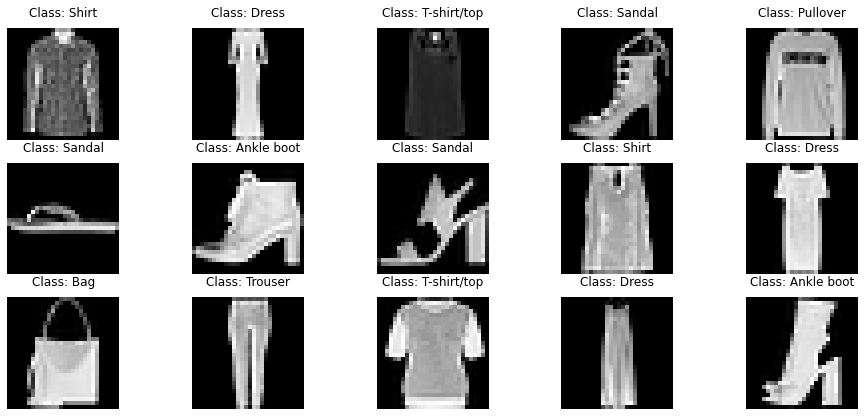

In [ ]:
plt.gray()
fig = plt.figure(figsize=(16, 7))
for i in range(0, 15):
    ax = fig.add_subplot(3, 5, i+1, title="Class: {}".format(str(data.loc[rndperm[i],'class'])) )
    ax.matshow(data.loc[rndperm[i],feat_cols].values.reshape((28, 28)).astype(float))
    ax.axis('off')
plt.show()

Ta bắt đầu thực hiện dimensionality reduction về 2 chiều bằng thuật toán t-SNE trên tập dữ liệu con.

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=500, random_state=10, learning_rate=200)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.149s...
[t-SNE] Computed neighbors for 10000 samples in 157.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 420.415178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.832077
[t-SNE] KL divergence after 500 iterations: 1.445398
t-SNE done! Time elap

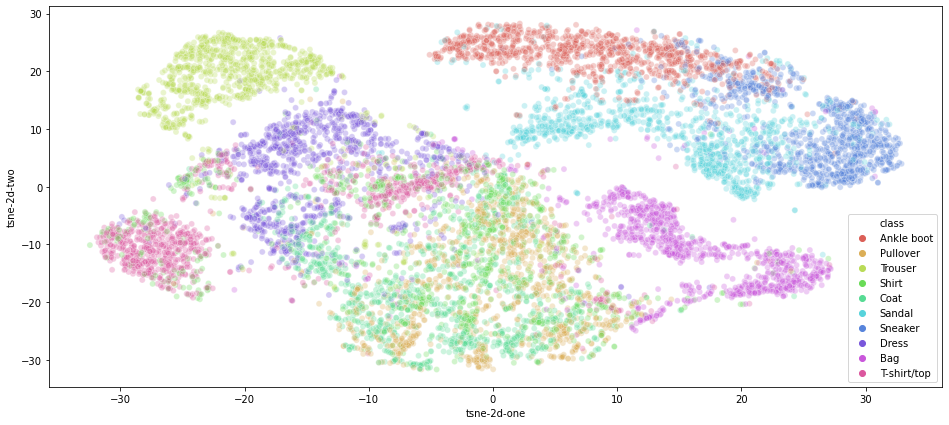

In [ ]:
fig, ax = plt.subplots(figsize=(16,7))
visualize_2D(df_subset, tsne_results, ax)
plt.show()

Ta show bộ dữ liệu embedded này bằng interactive plot 3D, với chiều thứ 3 là tên các class.

In [ ]:
interactive_3D_plot(df_subset, tsne_results)

Tiếp theo, ta thực hiện dimensionality reduction về 3 chiều bằng thuật toán t-SNE và plot với 2 dạng (thường và interactive)

In [ ]:
time_start = time.time()
tsne_3d = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=500, random_state=10, learning_rate=200)
tsne_results_3d = tsne_3d.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.391s...
[t-SNE] Computed neighbors for 10000 samples in 151.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 420.415178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.280869
[t-SNE] KL divergence after 500 iterations: 1.245096
t-SNE done! Time elap

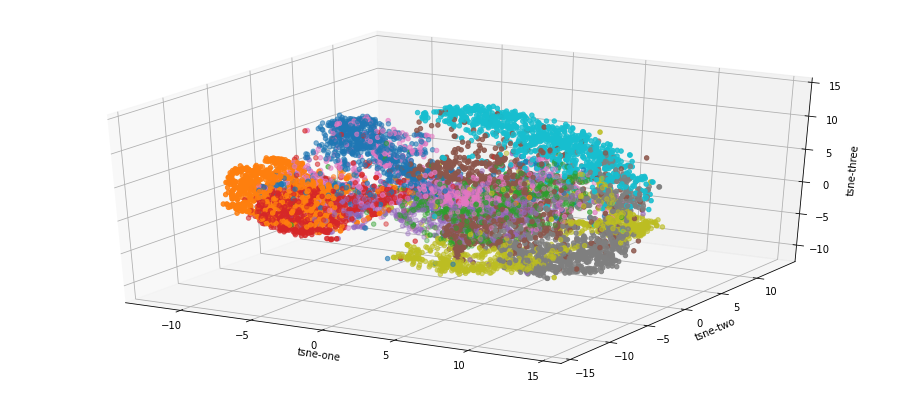

In [ ]:
ax = plt.figure(figsize=(16,7)).gca(projection='3d')
visualize_3D(df_subset, tsne_results_3d, ax)
plt.show()

In [ ]:
interactive_3D_plot(df_subset, tsne_results_3d)

Với nguyên lý hoạt động của thuật toán t-SNE, cách thuật toán thực hiện trên bộ dữ liệu gốc với số feature quá lớn (784) dẫn đến tình trạng lượng tính toán quá lớn và gây mất thời gian rất lâu. Điều đó sẽ có hạn chế rất nghiêm trọng khi sử dụng thuật toán này đối với dữ liệu có số chiều quá cao. Do đó, một đề nghị được đưa ra rằng ta cần dùng một kỹ thuật khác để giảm số chiều của dữ liệu trước khi sử dụng t-SNE. Cụ thể, ở đây ta sẽ sử dụng PCA để giảm số chiều của dữ liệu về lượng hợp lý (cụ thể là 90).

In [ ]:
pca_90 = PCA(n_components=90)
pca_result_90 = pca_90.fit_transform(data_subset)
print('Cumulative explained variation for 90 principal components: {}'.format(np.sum(pca_90.explained_variance_ratio_)))

Cumulative explained variation for 90 principal components: 0.9057208929801802


Ta thấy rằng, sau khi thực hiện PCA trên bộ dữ liệu gốc 784 chiều về còn 90 chiều, thì lượng thông tin giữ lại được còn đến 90% so với dữ liệu gốc.

Tiếp theo, ta thực hiện dimensionality reduction về 2 và 3 chiều bằng thuật toán t-SNE. Sau đó, so sánh kết quả với việc không thực hiện PCA trước.

In [ ]:
time_start = time.time()
pca_tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=500, random_state=10, learning_rate=200)
pca_tsne_results = pca_tsne.fit_transform(pca_result_90)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.154s...
[t-SNE] Computed neighbors for 10000 samples in 10.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 370.154908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.181061
[t-SNE] KL divergence after 500 iterations: 1.400906
t-SNE done! Time elaps

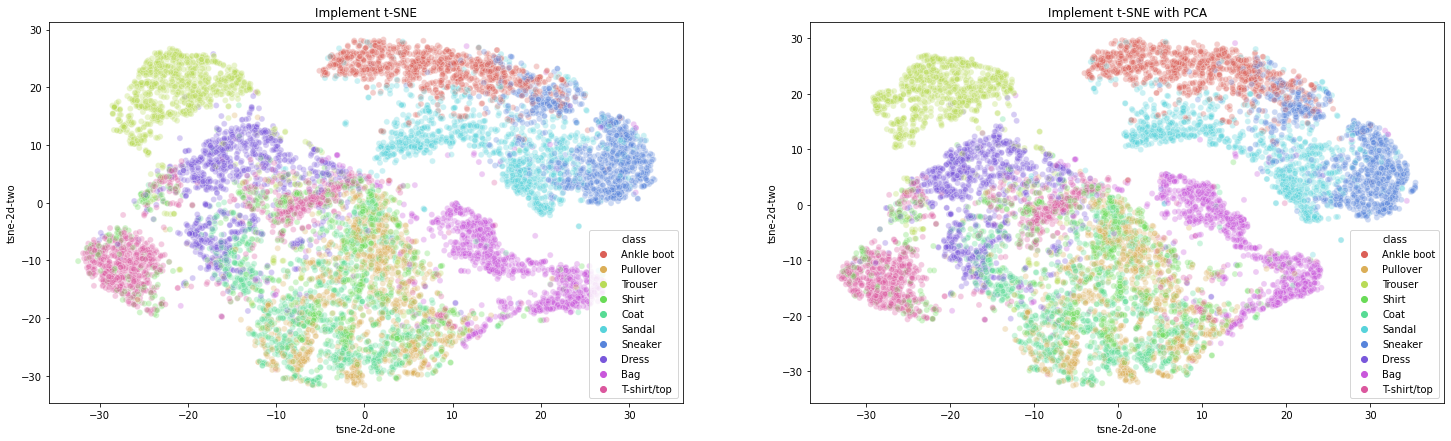

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(25,7))
visualize_2D(df_subset, tsne_results, axs[0])
axs[0].set_title('Implement t-SNE')
visualize_2D(df_subset, pca_tsne_results, axs[1])
axs[1].set_title('Implement t-SNE with PCA')
plt.show()

In [ ]:
time_start = time.time()
pca_tsne_3d = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=500, random_state=10, learning_rate=200)
pca_tsne_results_3d = pca_tsne_3d.fit_transform(pca_result_90)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.105s...
[t-SNE] Computed neighbors for 10000 samples in 10.859s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 370.154908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.665703
[t-SNE] KL divergence after 500 iterations: 1.192360
t-SNE done! Time elaps

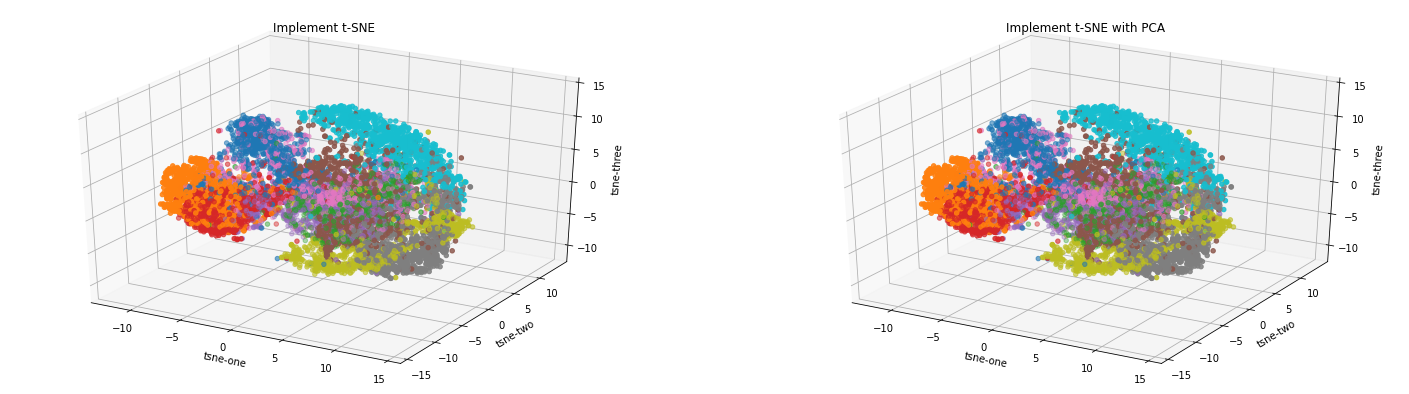

In [ ]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
visualize_3D(df_subset, tsne_results_3d, ax1)
ax1.set_title("Implement t-SNE")
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
visualize_3D(df_subset, pca_tsne_results_3d, ax2)
ax2.set_title("Implement t-SNE with PCA")
plt.show()

Ta dễ thấy rằng, so với việc không thực hiện PCA trước, kết quả cho ra nhanh hơn rất nhiều, mà quan trọng hơn là kết quả cho ra lại chênh lệch rất nhỏ, hầu như không ảnh hưởng nhiều. Điều đó cho thấy rằng, thuật toán t-SNE gặp khó khăn về mặt tính toán đối với bộ dữ liệu có số chiều lớn, khi đó ta có thể áp dụng một kỹ thuật dimensionality reduction khác để giảm số chiều gốc về số chiều vừa phải, sau đó thực hiện t-SNE để có thể visualize được nhanh và dễ dàng hơn.